Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
n_val_stop = 0
args = fovea.Params(do_fovea=True, n_val_stop=n_val_stop)
# args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-20-14	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-6.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=4, in_memory=False, model_name='convnext_base', num_epochs=24, n_train_stop=20480, n_val_stop=0, lr=1e-06, delta1=0.1, delta2=0.007, weight_decay=0.03, label_smoothing=0.2, shuffle=True, verbose=True)

# testing a ResNet model on the validation dataset

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
if False:
    val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
    fovea.get_loader(args, val_dataset)
    model = fovea.load_model(args)
    model.eval()
    print(f"Model {args.model_name} loaded.")

# testing the role of batch_size on Wall Clock Time 

In [3]:
fname = '12_batch_size.json'
json_filename = args.data_cache / fname

# %rm {json_filename} # FORCING RECOMPUTE

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for in_memory in [False, True]:
        batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
        pbar = fovea.tqdm(batch_sizes, desc='Testing Batch Sizes')
        val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, in_memory=in_memory, n_stop=args.n_val_stop)
        for batch_size in pbar :
            pbar.set_postfix({'current_batch_size': batch_size, 'in_memory':in_memory})

            args = fovea.Params(batch_size=batch_size, n_val_stop=n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            model = fovea.load_model(args)
            tic = fovea.time.time()
            accuracy = fovea.get_validation_accuracy(args, model, val_loader)
            toc = fovea.time.time()
            this_result = {         
                            'batch_size': batch_size,
                            'in_memory': in_memory,
                            'accuracy': accuracy,
                            'wall_clock_time': toc-tic,
                            }
            all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

In [4]:
results.T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
batch_size,2,4,8,16,32,64,128,256,512,1024,...,4,8,16,32,64,128,256,512,1024,2048
in_memory,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
accuracy,0.38886,0.38916,0.38846,0.3885,0.389925,0.387944,0.388842,0.388622,0.388068,0.386963,...,0.83946,0.83896,0.83908,0.839389,0.839529,0.838642,0.839383,0.83932,0.839213,0.838847
wall_clock_time,416.639404,327.349952,287.591863,271.384453,268.935038,268.460178,266.717291,268.251136,272.305617,270.68517,...,264.990236,219.226246,204.502314,198.996572,196.72004,198.442489,199.28476,211.894378,211.457515,209.509865


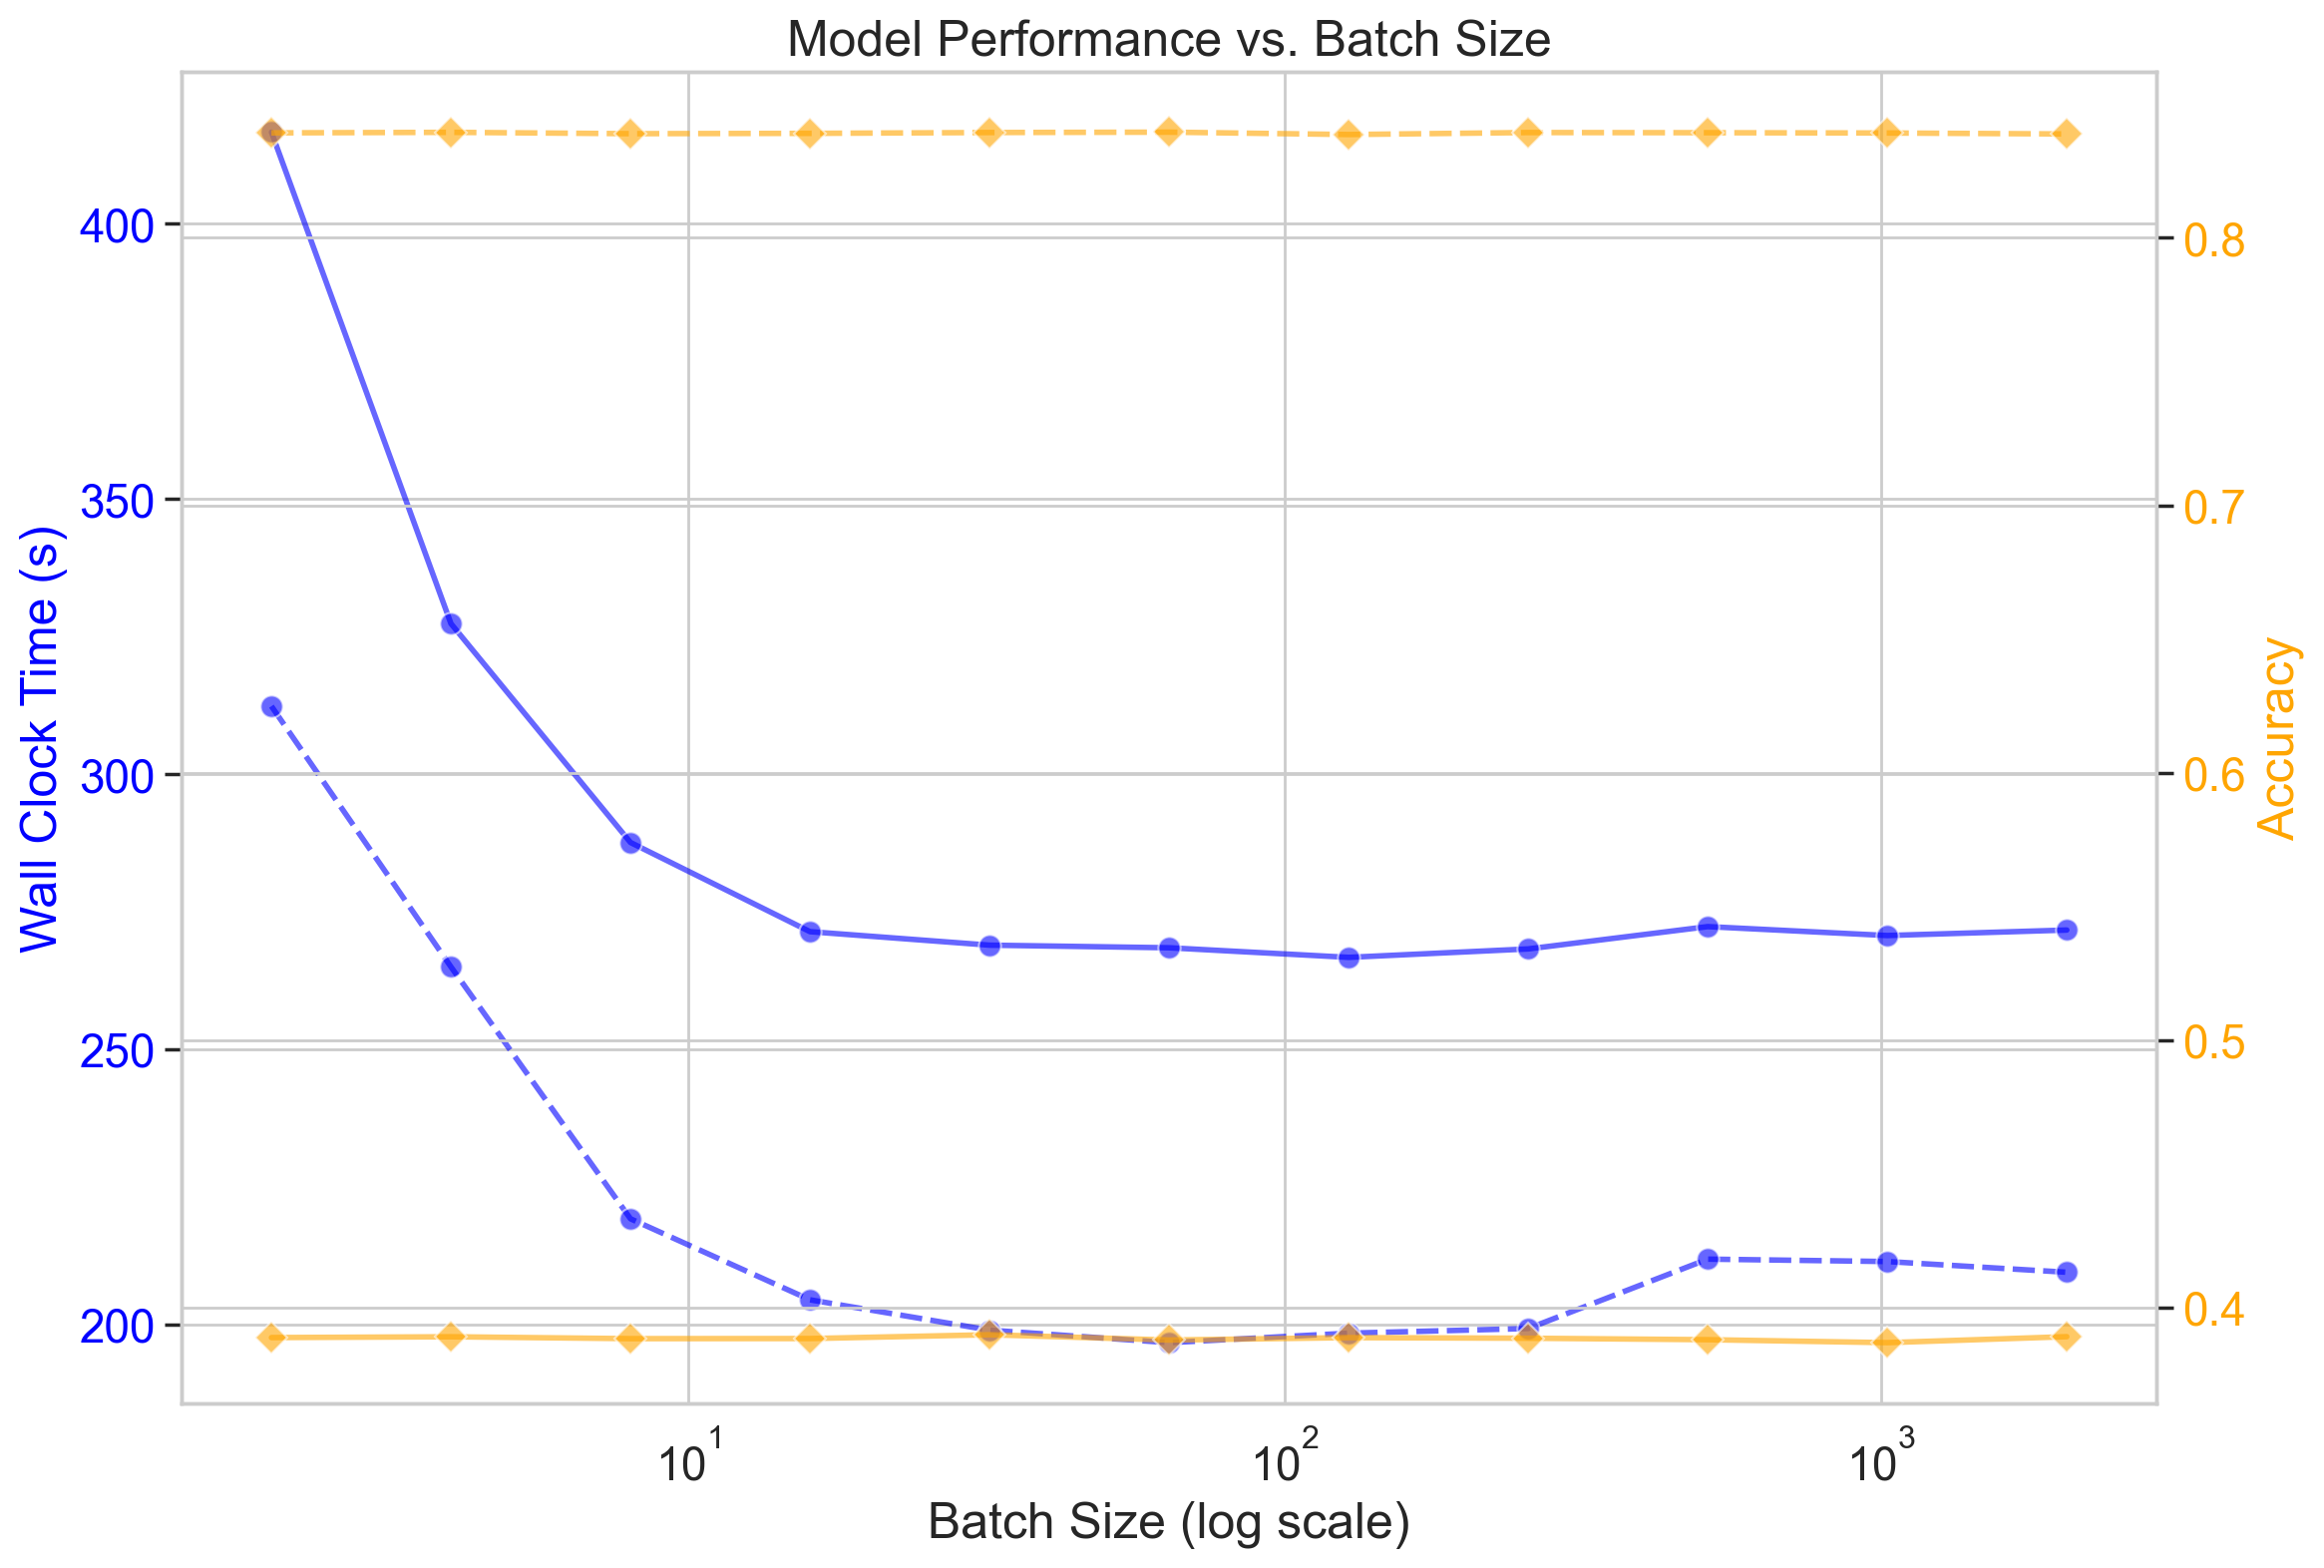

In [5]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    style='in_memory',          # Style by dataset
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='accuracy',
    color='orange',                # Set color to orange
    style='in_memory',          # Style by dataset
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)

# --- Final Touches ---
# Set log scale for the x-axis
ax.set_xscale('log')

# Set axis labels and title
ax.set_xlabel('Batch Size (log scale)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. Batch Size')

# # Create a single, unified legend
# # Get handles and labels from both axes
# h1, l1 = ax.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# # Combine them and place the legend
# ax.legend('acc', 'time', loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)
# # ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()

In [6]:
fovea.savefig(ax.get_figure(), name=fname, figures_folder=args.figures_folder, exts=['pdf'])    

# testing the role of `num_workers` on Wall Clock Time 

In [7]:
args.num_workers

4

In [8]:
fname = '12_num_workers.json'
json_filename = args.data_cache / fname

# %rm {json_filename}  # FORCING RECOMPUTE

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    # pbar = fovea.tqdm([0, 1, 2, 4, 8], desc='num_workers')
    pbar = fovea.tqdm([0, 1, 2, 4, 8, 16], desc='num_workers')
    # for in_memory in [False, True]:
    for in_memory in [False]:
        val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, in_memory=in_memory, n_stop=args.n_val_stop)

        for num_workers in pbar:
            pbar.set_postfix({'num_workers': num_workers, 'in_memory':in_memory})
            args = fovea.Params(num_workers=num_workers, n_val_stop=n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            model = fovea.load_model(args)
            tic = fovea.time.time()
            accuracy = fovea.get_validation_accuracy(args, model, val_loader)
            toc = fovea.time.time()
            this_result = {         
                            'num_workers': num_workers,
                            'in_memory': in_memory,
                            'accuracy': accuracy,
                            'wall_clock_time': toc-tic,
                            }
            all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

num_workers:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating convnext_base:   0%|          | 0/625 [00:00<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-24-48	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Evaluating convnext_base:   0%|          | 0/625 [00:01<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-24-49	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-27-21	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-27-22	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Evaluating convnext_base:   0%|          | 0/625 [00:03<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-27-24	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-27-26	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-02	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-04	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30

Evaluating convnext_base:   0%|          | 0/625 [00:07<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-10	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-12	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-13	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-30-15	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33

Evaluating convnext_base:   0%|          | 0/625 [00:14<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33-16	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33-18	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33-19	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33-21	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-33

Evaluating convnext_base:   0%|          | 0/625 [00:29<?, ?it/s]

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-36-23	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-36-25	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-36-27	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-36-29	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	- Timestamp (UTC)  2025-12-04_13-36

In [9]:
results.T

,0,1,2,3,4,5
num_workers,0,1,2,4,8,16
in_memory,False,False,False,False,False,False
accuracy,0.38886,0.3885,0.3877,0.38912,0.3893,0.3873
wall_clock_time,269.840001,147.333533,151.100265,158.379651,172.136807,201.246124


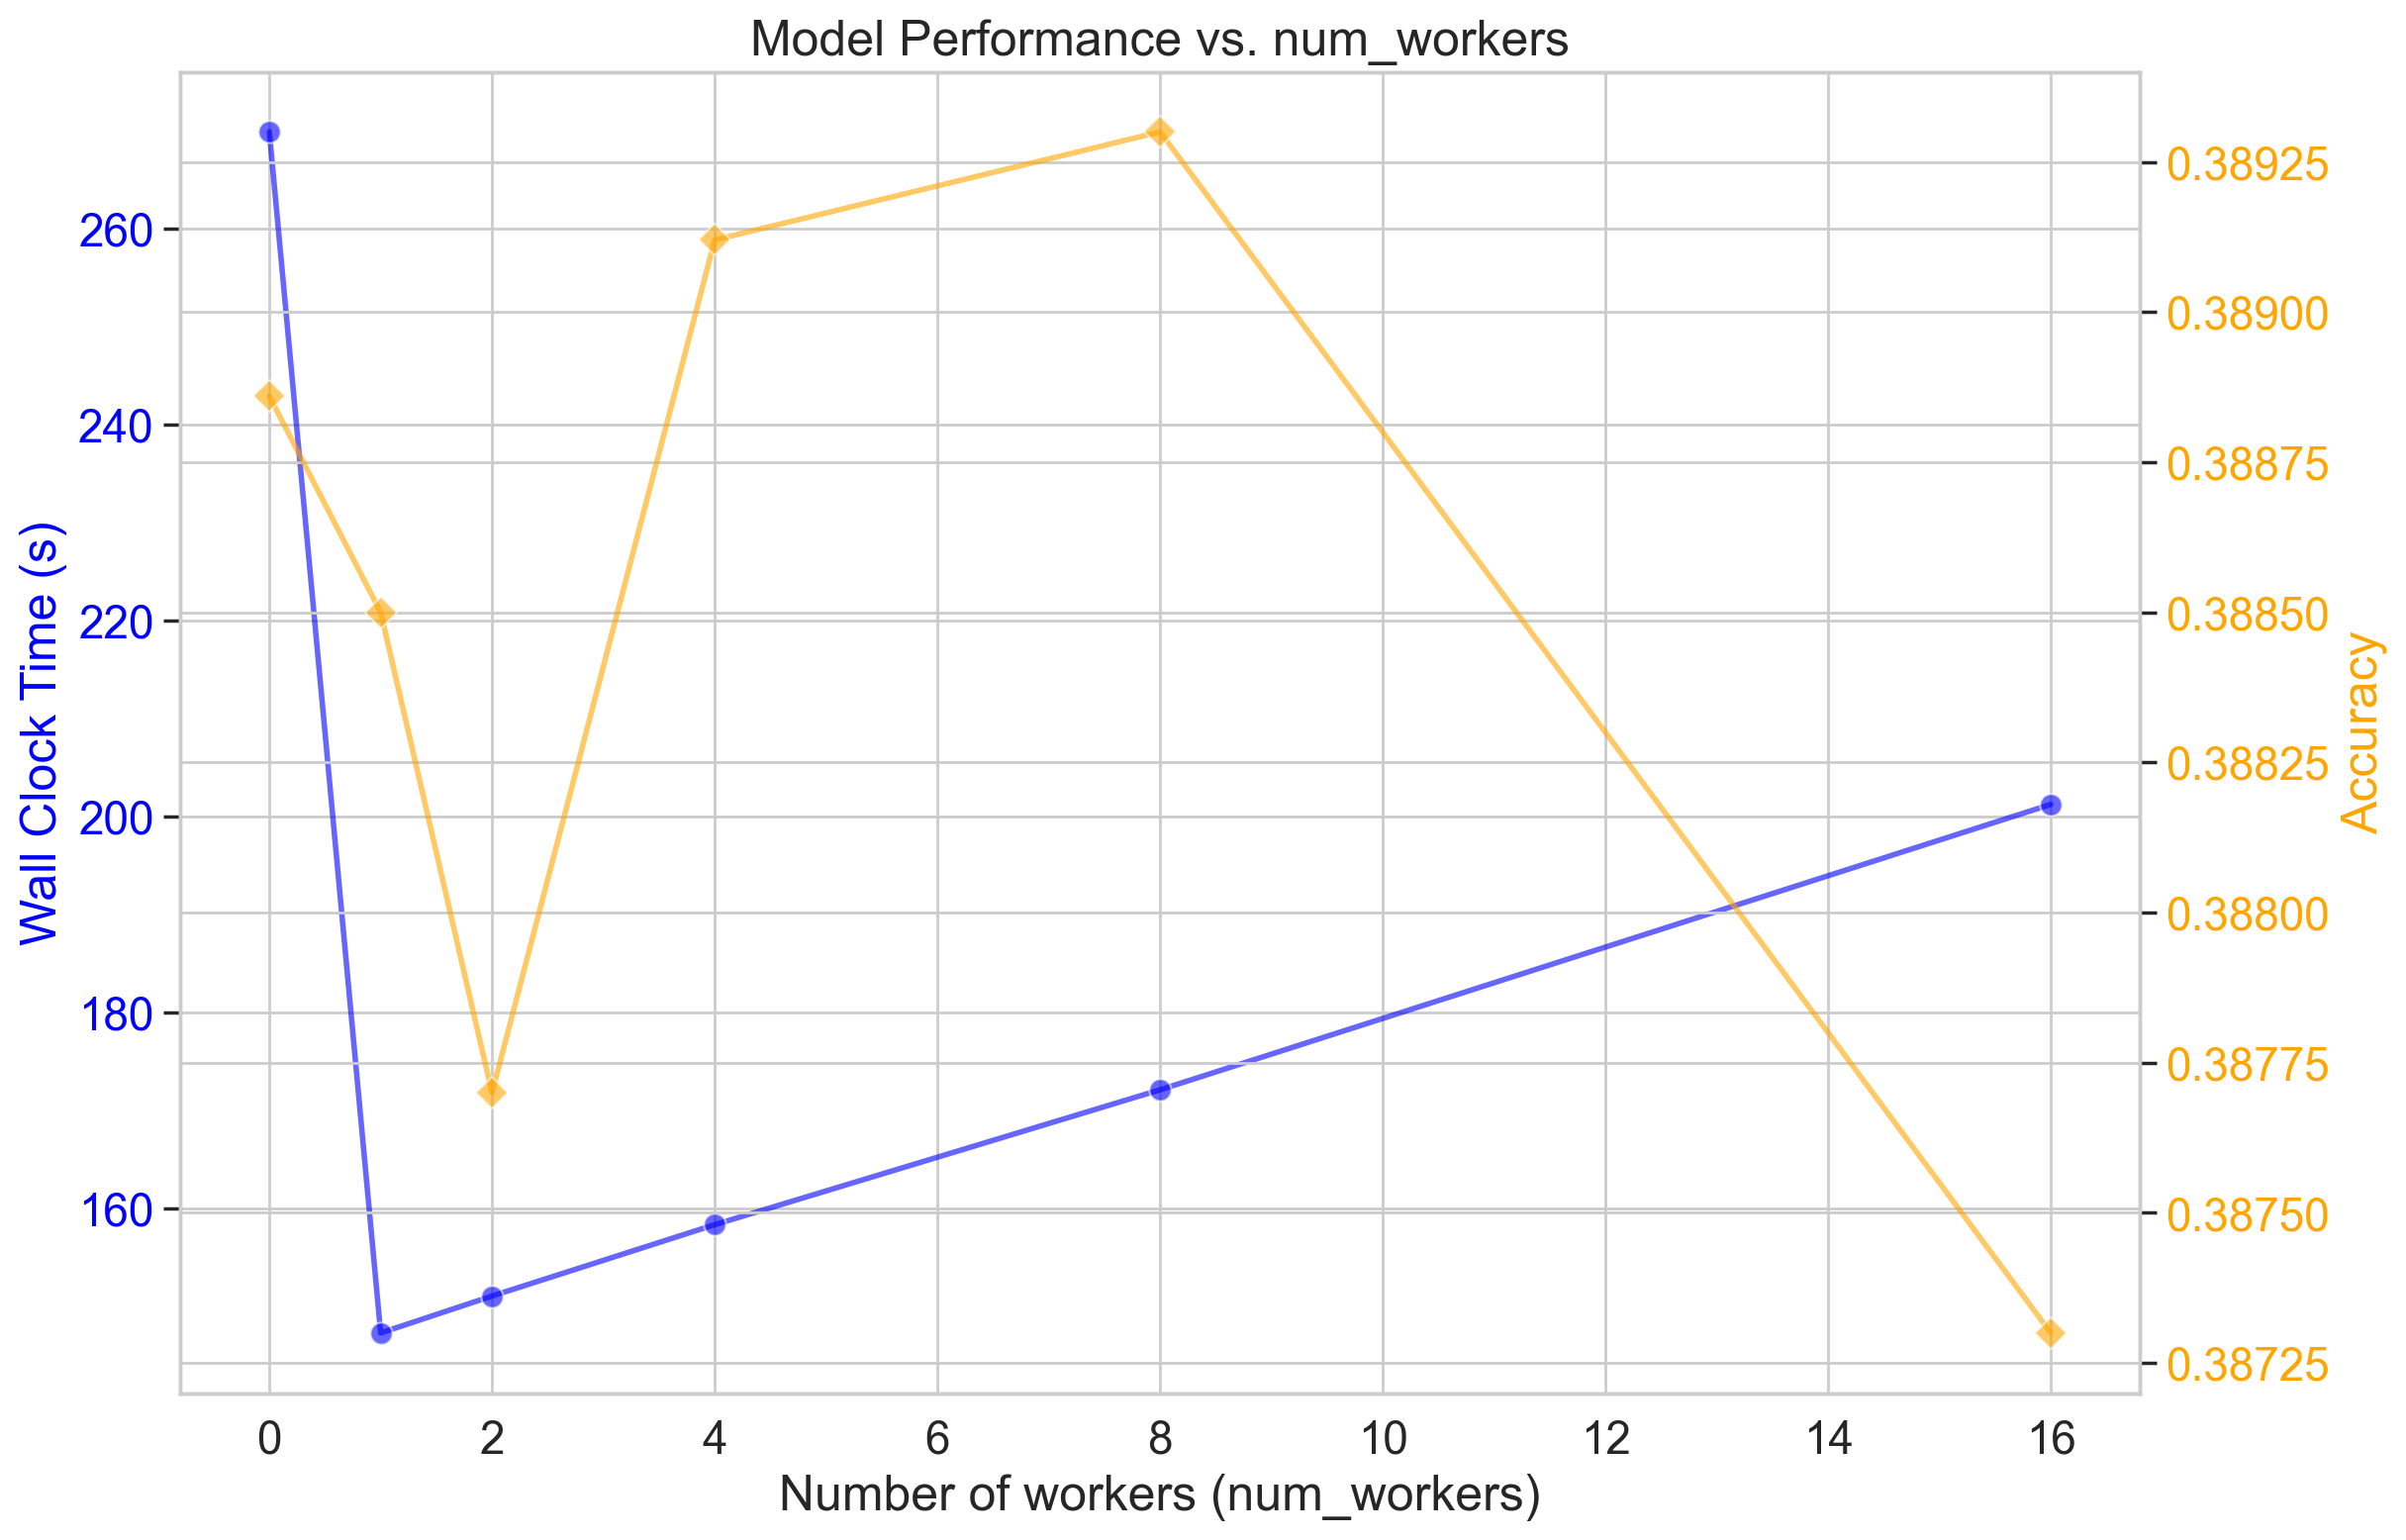

In [10]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation

ax = fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    style='in_memory',          # Style by dataset
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='accuracy',
    color='orange',                # Set color to orange
    style='in_memory',          # Style by dataset
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)



# Set axis labels and title
ax.set_xlabel('Number of workers (num_workers)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. num_workers')

# # Create a single, unified legend
# # Get handles and labels from both axes
# h1, l1 = ax.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# # Combine them and place the legend
# ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)

# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()

In [11]:
fovea.savefig(ax.get_figure(), name=fname, figures_folder=args.figures_folder, exts=['pdf'])    